
<h2 style="color:red"> This file is deprecated. Please look at ActivityNet-Release1.3.Proposals.ipynb notebook</h2>


# ActivityNet Challenge Agnostic Temporal Proposals
This notebook is intended as demo on how to use the temporal proposals provided for the ActivityNet Challenge CVPR 2016. Additionally, recall performance is reported.

In [1]:
import json

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

Load annotations for validation subset in a Pandas Data Frame.

In [2]:
# Modify this paths
ANNOTATION_FILE = 'activity_net.v1-3.min.json'
PROPOSALS_FILENAME = 'activitynet_v1-3_proposals.hdf5'
SUBSET = 'validation'

In [3]:
# Read json file containing the annotations
with open(ANNOTATION_FILE, 'r') as fobj:
    data = json.load(fobj)['database']

# Parsing and looking for agnostic segments of an intended subset.
video_id_fmt = 'v_{}'
gt_s_init, gt_s_end, video_id = [], [], []
for vid, vitem in data.iteritems():
    if vitem['subset'] != SUBSET:
        continue
    for ann in vitem['annotations']:
        gt_s_init.append(ann['segment'][0])
        gt_s_end.append(ann['segment'][1])
        video_id.append(video_id_fmt.format(vid))
# Creates ground truth data frame.
ground_truth_df = pd.DataFrame({'s-init': gt_s_init, 
                                's-end': gt_s_end,
                                'video-id': video_id})

Load temporal proposals in a Pandas Data Frame.

In [4]:
# Looking for videos in the subset
intended_videos = []
for vid, vitem in data.iteritems():
    if vitem['subset'] == SUBSET:
        intended_videos.append('v_{}'.format(vid))

# Reading proposals from HDF5 file.
s_init, s_end, score, video_id = [], [], [], []
fobj = h5py.File(PROPOSALS_FILENAME, 'r')
for vid in fobj.keys():
    if vid not in intended_videos:
        continue
    s_init.extend(fobj[vid]['segment-init'].value.tolist())
    s_end.extend(fobj[vid]['segment-end'].value.tolist())
    score.extend(fobj[vid]['score'].value.tolist())
    video_id.extend(np.repeat(vid, fobj[vid]['segment-init'].value.size).tolist())
fobj.close()
proposals_df = pd.DataFrame({'s-init': s_init, 
                             's-end': s_end, 
                             'score': score,
                             'video-id': video_id})
print 'Average number of proposals: {}'.format(proposals_df.shape[0] / float(len(intended_videos)))

Average number of proposals: 89.6140885099


Subrutines to compute temporal IoU and wrapper for recall

In [5]:
def segment_iou(target_segments, test_segments):
    """Compute intersection over union btw segments
    Parameters
    ----------
    target_segments : ndarray
        2-dim array in format [m x 2:=[init, end]]
    test_segments : ndarray
        2-dim array in format [n x 2:=[init, end]]
    Outputs
    -------
    iou : ndarray
        2-dim array [m x n] with IOU ratio.
    Note: It assumes that target-segments are more scarce that test-segments
    """
    if target_segments.ndim != 2 or test_segments.ndim != 2:
        raise ValueError('Dimension of arguments is incorrect')

    m, n = target_segments.shape[0], test_segments.shape[0]
    iou = np.empty((m, n))
    for i in xrange(m):
        tt1 = np.maximum(target_segments[i, 0], test_segments[:, 0])
        tt2 = np.minimum(target_segments[i, 1], test_segments[:, 1])

        # Non-negative overlap score
        intersection = (tt2 - tt1).clip(0)
        union = ((test_segments[:, 1] - test_segments[:, 0]) +
                 (target_segments[i, 1] - target_segments[i, 0]) -
                 intersection)
        # Compute overlap as the ratio of the intersection
        # over union of two segments at the frame level.
        iou[i, :] = intersection / union
    return iou

def recall_vs_iou_thresholds(proposal_df, df, iou_threshold=np.array([0.5])):
    vds = proposal_df['video-id'].unique()
    score_lst = []
    # Compute iou score
    for i, v in enumerate(vds):
        # Proposals
        idx = proposal_df['video-id'] == v
        this_df = proposal_df.loc[idx]
        proposals = np.stack((this_df['s-init'], 
                              this_df['s-end']), axis=-1)

        # Sort proposals
        idx = this_df['score'].argsort()[::-1]
        proposals = proposals[idx, :]

        # Annotations
        jdx = df['video-id'] == v
        ann_df = df.loc[jdx]
        annotations = np.stack((ann_df['s-init'],
                                ann_df['s-end']), axis=-1)
        if proposals.ndim == 1:
            proposals = proposals[np.newaxis, :]
        score_lst.append(segment_iou(annotations, proposals))
        if not (i+1)%500:
            print 'Scored videos: {}'.format(i+1)
    matches = np.zeros((vds.shape[0], iou_threshold.shape[0]))
    pos = np.zeros(vds.shape[0])
    # Matching
    recall = np.empty(iou_threshold.shape[0])
    for cidx, this_iou in enumerate(iou_threshold):
        # Score analysis per video.
        for i, sc in enumerate(score_lst):
            pos[i] = sc.shape[0] # Positives per video.
            lmt = int(sc.shape[1])
            matches[i, cidx] = ((sc[:, :lmt] >= this_iou).sum(axis=1) > 0).sum()
        this_recall = matches[:, cidx].sum() / pos.sum()
        recall[cidx] = this_recall
    return recall

Lets compute the Recall at different Temporal IoU thresholds

In [6]:
iou_thrs = np.arange(0.1, 0.6, 0.1)
recall = recall_vs_iou_thresholds(proposals_df, ground_truth_df, iou_threshold=iou_thrs)

Scored videos: 500
Scored videos: 1000
Scored videos: 1500
Scored videos: 2000
Scored videos: 2500
Scored videos: 3000
Scored videos: 3500
Scored videos: 4000
Scored videos: 4500


/usr/lib/python2.7/site-packages/ipykernel/__main__.py:47: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Recall vs Temporal IoU curve

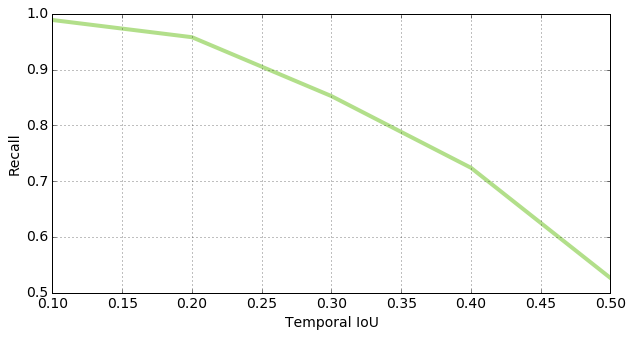

In [7]:
fn_size = 14
plt.figure(num=None, figsize=(10, 5))
plt.plot(iou_thrs, recall, linewidth=4, color=np.array([178,223,138])/255.0)
plt.xlabel('Temporal IoU', fontsize=fn_size)
plt.ylabel('Recall', fontsize=fn_size)
plt.grid(b=True, which="both")
plt.setp(plt.axes().get_xticklabels(), fontsize=fn_size)
plt.setp(plt.axes().get_yticklabels(), fontsize=fn_size)
plt.xlim([0.1, 0.5])
plt.show()